## Data loading

In the last exercises, we took care of the dataloading and mini-batching for you. With PyTorch, this task is considerably easier, so let's do it ourselves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

/home/gandalf/miniconda3/envs/deep_learning_ex_1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/gandalf/miniconda3/envs/deep_learning_ex_1/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

0.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




4.0%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28 at 0x7FB16D057370>, 5)


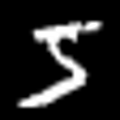

In [3]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.0), (1.0))
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a torch tensor

In [5]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [6]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [7]:
(std, mu) = torch.std_mean(ims_train)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 2 workers (number of subprocess that peform the dataloading. Important: you need to shuffle the training data, not the test data.

In [11]:
dl_train = DataLoader(dataset=ds_train, batch_size=64, shuffle=True, num_workers=2)
dl_test = DataLoader(dataset=ds_test, batch_size=64, shuffle=False, num_workers=2)

In [9]:
?DataLoader

Init signature:
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, cus

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises.

In [12]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 1
nHidden = 64
act_fn = nn.ReLU()

In [22]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

def fc_layer(c_in, c_out, act_func):
    return nn.Sequential(nn.Linear(c_in, c_out), act_fn)

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        layers += fc_layer(nInput, nHidden, nn.ReLU())

        for _ in range(nLayer):
            layers += fc_layer(nHidden, nHidden, nn.ReLU())
    
        layers += fc_layer(nHidden, nOutput, nn.ReLU())
                            
        layers.append([nn.LogSoftmax(dim=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [23]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

We already implemented the test function for you

In [24]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now we only need to implement the training and we are good to go

In [42]:
def train(model, dl_train, optimizer, epoch, log=True, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####
        
        output = model(data)
        loss = F.nll_loss(output, target=target)
        
        loss.backward()
        
        optimizer.step()
        
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if log and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))
    if log:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            loss, correct, len(dl_train.dataset),
            100. * correct / len(dl_train.dataset)))

In [ ]:
??torch.mean

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use AdaDelta. You already saw AdaGrad in the last exercise, AdaDelta is a version of AdaGrad.

In [32]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, 0, nHidden, act_fn)
learning_rate = 1.0
optimizer = optim.Adadelta(mlp.parameters(), lr=learning_rate)

In [35]:
# if you have a GPU available or you are using google colab with a GPU environment 
# (torch.cuda.is_available should be True), you can add an additional argument device='cuda'
# to both train and test functions, and move mlp to GPU (mlp = mlp.to('cuda'))
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log=True, log_interval=100)
    test(mlp, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.002571
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.047185
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.003617
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.011074
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000772
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.002557
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000632
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.007219
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.045224
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.070567

Train set: Average loss: 0.0342, Accuracy: 59555/60000 (99.3%)


Test set: Average loss: 0.1104, Accuracy: 9745/10000 (97.450%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001161
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.001470
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.004568
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.084617
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.181823
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.003945
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000339
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > 96% - this is the performance we saw in our last experiments with EDF. By the way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Before you move on to the next exercise, you should play with the different parameters (learning rate, epochs, number of hidden layers, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

In [44]:
lrs = [0.01, 0.1, 0.5]
eps = [5, 10]
hlyrs = [0, 1, 2]
sizes = [32, 64, 182]
optims = [optim.Adam, optim.NAdam]

for l in lrs:
    for e in eps:
        for h in hlyrs:
            for s in sizes:
                for o in optims:
                    print(f"{l}, {e}, {h}, {s}, {o}")
                    test_params(l, e, h, s, o)


def test_params(l, e, h, s, o):

    mlp = MLP(nInput, nOutput, h, s, act_fn)
    optimizer = o(mlp.parameters(), lr=l)
    
    for epoch in range(1, e + 1):
        train(mlp, dl_train, optimizer, epoch, log=False)
    
    test(mlp, dl_test)


0.01, 5, 0, 32, <class 'torch.optim.adam.Adam'>

Test set: Average loss: 0.6494, Accuracy: 7623/10000 (76.230%)


Test set: Average loss: 0.6566, Accuracy: 7589/10000 (75.890%)


Test set: Average loss: 0.6573, Accuracy: 7606/10000 (76.060%)


Test set: Average loss: 0.6640, Accuracy: 7600/10000 (76.000%)


Test set: Average loss: 0.6988, Accuracy: 7431/10000 (74.310%)

0.01, 5, 0, 32, <class 'torch.optim.nadam.NAdam'>

Test set: Average loss: 0.8676, Accuracy: 6688/10000 (66.880%)


Test set: Average loss: 0.8590, Accuracy: 6657/10000 (66.570%)


Test set: Average loss: 0.8528, Accuracy: 6710/10000 (67.100%)


Test set: Average loss: 0.8682, Accuracy: 6701/10000 (67.010%)


Test set: Average loss: 0.8391, Accuracy: 6702/10000 (67.020%)

0.01, 5, 0, 64, <class 'torch.optim.adam.Adam'>

Test set: Average loss: 0.4630, Accuracy: 8362/10000 (83.620%)


Test set: Average loss: 0.2468, Accuracy: 9360/10000 (93.600%)


Test set: Average loss: 0.2427, Accuracy: 9350/10000 (93.500%)


Test set

KeyboardInterrupt: 

## CNN
Alright, we matched our prior performance. Let's surpass it!
We will build a small CNN. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|
| Log softmax (see above in MLP definition)    	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear, nn.ReLU,  nn.Dropout, nn.MaxPool2d, nn.LogSoftmax, nn.Flatten`

For layers with out parameters you can alternatively use function in the forward pass:  

`F.relu, F.max_pool2d, torch.flatten, F.log_softmax`

In [ ]:
class PrinterModule(nn.Module):
    def forward(x):
        print(x.shape)
        return x

In [50]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        layers = []
        
        layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        layers.append(nn.Dropout(p=0.25))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=9216, out_features=128))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.5))
        layers.append(nn.Linear(in_features=128, out_features=10))
        layers.append(nn.LogSoftmax(dim=1))
        
        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)

In [51]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [52]:
learning_rate = 1.0
optimizer = optim.Adadelta(cnn.parameters(), lr=learning_rate)

In [54]:
# if you have a GPU available or you are using google colab with a GPU environment 
# (torch.cuda.is_available should be True), you can add an additional argument device='cuda'
# to both train and test functions, and move cnn to GPU (cnn = cnn.to('cuda'))
epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.014645
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.005518
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.015431
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.009321
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.066880
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.001795
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.079328
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.022146
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.052973
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.013047

Train set: Average loss: 0.0022, Accuracy: 59288/60000 (98.8%)


Test set: Average loss: 0.0331, Accuracy: 9911/10000 (99.110%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003234
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.031607
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000219
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.005963
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.005711
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.002956
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.073560
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around 99% accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [55]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [ ]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [ ]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu = 0.0
std = 1.0

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations that are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [ ]:
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 2 workers
#
# Train: 
# - Apply a random crop with sz 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
transform_train = None
transform_test = None

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = None
dl_test = None

Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [ ]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [ ]:
#########################################################################
# TODO: Adapt the definition from above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

    def forward(self, x):
        pass

Let's try again

In [ ]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

It as easy as:

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backend.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
cnn = resnet18()
cnn

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion. 

In [ ]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################


In [ ]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should get us well above 75%, the best we got was ~ 80%.

Bonus Task: Use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %